In [353]:
import lilio
import urllib
import xarray as xr
from s2spy import preprocess
from s2spy import RGDR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from skl2onnx import to_onnx
import numpy as np
import onnxruntime as ort

In [354]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01", allow_overlap=True)
# add target periods
calendar.add_intervals("target", length="30d")
# add precursor periods
periods_of_interest = 8
calendar.add_intervals("precursor", "1M", gap="1M", n=periods_of_interest)

In [355]:
# URL of the dataset from zenodo
sst_url = "https://zenodo.org/record/8186914/files/sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc"
t2m_url = "https://zenodo.org/record/8186914/files/t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc"
sst_field = "sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc"
t2m_field = "t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc"

urllib.request.urlretrieve(sst_url, sst_field)
urllib.request.urlretrieve(t2m_url, t2m_field)

('t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc',
 <http.client.HTTPMessage at 0x2bd458370>)

In [356]:
# load data
precursor_field = xr.open_dataset(sst_field)
target_field = xr.open_dataset(t2m_field)

In [357]:
# Convert Kelvin to Celsius
precursor_field["sst"] = precursor_field["sst"] - 273.15
target_field["t2m"] = target_field["t2m"] - 273.15

target_field

<xarray.Dataset> Size: 740kB
Dimensions:     (time: 23011, cluster: 6, longitude: 38, latitude: 21)
Coordinates:
  * time        (time) datetime64[ns] 184kB 1959-01-01 1959-01-02 ... 2021-12-31
    n_clusters  int64 8B ...
  * cluster     (cluster) int64 48B 1 2 3 4 5 6
  * longitude   (longitude) float64 304B 226.0 228.0 230.0 ... 296.0 298.0 300.0
  * latitude    (latitude) float32 84B 30.0 32.0 34.0 36.0 ... 66.0 68.0 70.0
Data variables:
    t2m         (cluster, time) float32 552kB -24.87 -32.5 ... 10.93 13.24
    xrcluster   (latitude, longitude) float32 3kB ...
Attributes:
    history:  The dataset contains 2 meter temperature clustered using Agglom...
    source:   ERA5

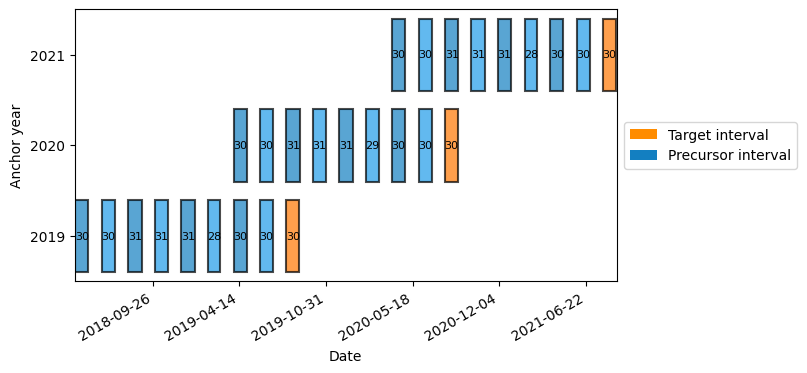

In [358]:
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

In [359]:
# get 70% of instance as training
years = sorted(calendar.get_intervals().index)
train_samples = round(len(years) * 0.7)
start_year = years[0]

train_slice = precursor_field.sel(time=slice(str(start_year), str(start_year + train_samples - 1)))
train_slice

<xarray.Dataset> Size: 4MB
Dimensions:    (time: 15706, longitude: 13, latitude: 5)
Coordinates:
  * time       (time) datetime64[ns] 126kB 1960-01-01 1960-01-02 ... 2002-12-31
  * longitude  (longitude) float64 104B 177.5 182.5 187.5 ... 227.5 232.5 237.5
  * latitude   (latitude) float64 40B 47.5 42.5 37.5 32.5 27.5
Data variables:
    sst        (time, latitude, longitude) float32 4MB 3.896 3.967 ... 18.25
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jun 14 17:26:04 2023: cdo remapbil,/Users/semv/surfdriv...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

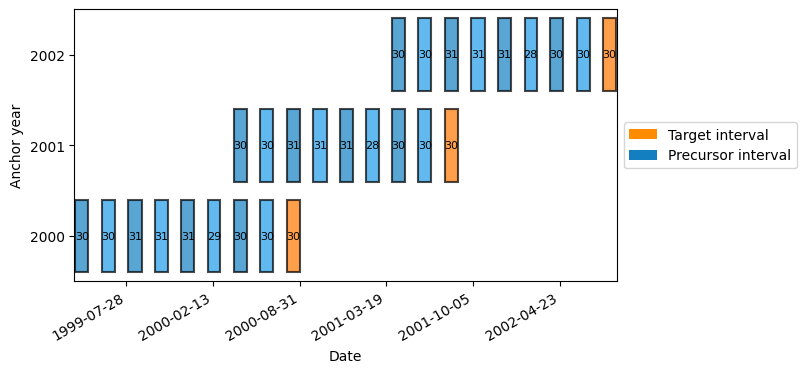

In [360]:
calendar.map_to_data(train_slice)
calendar.visualize(show_length=True)

In [361]:
test_samples = round(len(years)*0.3)
end_year = years[-1]
test_slice = precursor_field.sel(time=slice(str(start_year + train_samples), str(end_year -1)))
test_slice

<xarray.Dataset> Size: 2MB
Dimensions:    (time: 6575, longitude: 13, latitude: 5)
Coordinates:
  * time       (time) datetime64[ns] 53kB 2003-01-01 2003-01-02 ... 2020-12-31
  * longitude  (longitude) float64 104B 177.5 182.5 187.5 ... 227.5 232.5 237.5
  * latitude   (latitude) float64 40B 47.5 42.5 37.5 32.5 27.5
Data variables:
    sst        (time, latitude, longitude) float32 2MB 3.667 4.027 ... 18.89
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jun 14 17:26:04 2023: cdo remapbil,/Users/semv/surfdriv...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

In [362]:
target_train_slice = target_field.sel(time=slice(str(start_year), str(start_year + train_samples - 1)))
target_test_slice = target_field.sel(time=slice(str(start_year + train_samples), str(end_year -1)))

In [363]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    timescale="monthly",
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(train_slice)

The temporal resolution of data does not completely match the target timescale. Please check your input data.


In [364]:
train_prep = preprocessor.transform(train_slice)

In [365]:
precursor_field_resample = lilio.resample(calendar, train_prep)
target_field_resample = lilio.resample(calendar, target_train_slice)

precursor_field_resample

<xarray.Dataset> Size: 203kB
Dimensions:      (anchor_year: 42, i_interval: 9, latitude: 5, longitude: 13)
Coordinates:
  * anchor_year  (anchor_year) int64 336B 1961 1962 1963 1964 ... 2000 2001 2002
  * i_interval   (i_interval) int64 72B -8 -7 -6 -5 -4 -3 -2 -1 1
  * longitude    (longitude) float64 104B 177.5 182.5 187.5 ... 232.5 237.5
  * latitude     (latitude) float64 40B 47.5 42.5 37.5 32.5 27.5
    left_bound   (anchor_year, i_interval) datetime64[ns] 3kB 1960-04-01 ... ...
    right_bound  (anchor_year, i_interval) datetime64[ns] 3kB 1960-05-01 ... ...
    is_target    (i_interval) bool 9B False False False ... False False True
Data variables:
    sst          (anchor_year, i_interval, latitude, longitude) float64 197kB ...
Attributes:
    lilio_version:               0.5.0
    lilio_calendar_anchor_date:  08-01
    lilio_calendar_code:         Calendar(\n    anchor='08-01',\n    allow_ov...
    history:                     2024-07-11 10:07:36 UTC - Resampled with a L...

In [366]:
precursor_field_sel = precursor_field_resample['sst']
target_series_sel = target_field_resample['t2m'].sel(cluster=3)

precursor_field_sel

<xarray.DataArray 'sst' (anchor_year: 42, i_interval: 9, latitude: 5,
                         longitude: 13)> Size: 197kB
array([[[[-3.49072905e-01, -4.87465680e-01, -3.64992271e-01, ...,
           3.76416839e-01,  2.11293734e-01,             nan],
         [-1.19766382e+00, -8.46902846e-01, -8.32997627e-01, ...,
           9.97585996e-02,  4.15884721e-01,             nan],
         [-1.86841278e-01, -6.90315065e-01, -5.91463191e-01, ...,
           1.18804303e-01,  6.22591440e-01,             nan],
         [ 4.46988002e-01, -2.81798946e-01, -2.63444383e-01, ...,
           9.71015815e-02,  3.89576514e-01,  4.42625692e-01],
         [ 9.09778202e-01,  4.04623776e-01, -1.93601826e-01, ...,
           2.87279068e-01,  6.98979043e-01,  7.21656965e-01]],

        [[-5.29288522e-01, -6.78476531e-01, -8.09646150e-01, ...,
           3.40932357e-01,  4.66771901e-01,             nan],
         [-1.52815911e+00, -1.43967231e+00, -1.41322891e+00, ...,
          -3.37068457e-02,  3.98212051e-01,             nan],
         [-9.40798737e-01, -7.03456419e-01, -8.65249564e-01, ...,
           3.14236415e-01, -7.35533031e-02,             nan],
         [-8.65088873e-01, -4.75384620e-01,  8.66528978e-02, ...,
           2.75211089e-01, -6.63064197e-02,  8.12748118e-02],
         [ 6.82464843e-01,  7.38650562e-01,  5.61992178e-01, ...,
...
           4.50101196e-02, -5.27158545e-01,             nan],
         [ 4.09409316e-01, -9.76804524e-02,  2.15991260e-02, ...,
           2.58026278e-01, -8.48256550e-02,             nan],
         [ 6.48349435e-01,  2.55260975e-01,  3.88472198e-02, ...,
          -3.60057695e-04, -9.43541243e-01,             nan],
         [ 3.31867171e-01, -1.34857371e-02, -2.43504266e-01, ...,
          -1.91283715e-01, -7.83110935e-01, -9.49220528e-01],
         [ 4.46572156e-01, -2.46071808e-02, -1.30603034e-01, ...,
          -6.21864183e-01, -5.85662304e-01, -4.61525056e-01]],

        [[-6.43399334e-01, -5.20432726e-01, -6.82358346e-01, ...,
           6.81300628e-01, -9.14384324e-01,             nan],
         [-5.56670617e-01, -1.04668441e+00, -8.79978501e-01, ...,
           3.50396315e-01, -1.24818628e-01,             nan],
         [-2.23795311e-02, -1.12990218e+00, -1.00657141e+00, ...,
          -1.32491486e-01, -7.37793451e-01,             nan],
         [ 5.61079562e-01,  7.86373032e-01,  9.54164325e-01, ...,
          -2.31732456e-01, -5.49381798e-01, -3.68206080e-01],
         [ 1.45818842e+00,  1.29158450e+00,  9.10519152e-01, ...,
          -4.40150809e-01, -5.49274568e-01, -3.70875564e-01]]]])
Coordinates:
  * anchor_year  (anchor_year) int64 336B 1961 1962 1963 1964 ... 2000 2001 2002
  * i_interval   (i_interval) int64 72B -8 -7 -6 -5 -4 -3 -2 -1 1
  * longitude    (longitude) float64 104B 177.5 182.5 187.5 ... 232.5 237.5
  * latitude     (latitude) float64 40B 47.5 42.5 37.5 32.5 27.5
    left_bound   (anchor_year, i_interval) datetime64[ns] 3kB 1960-04-01 ... ...
    right_bound  (anchor_year, i_interval) datetime64[ns] 3kB 1960-05-01 ... ...
    is_target    (i_interval) bool 9B False False False ... False False True

In [394]:
# cross-validation with Kfold
k_fold_splits = 5
kfold = KFold(n_splits=k_fold_splits)
cv = lilio.traintest.TrainTestSplit(kfold)

# create lists for saving models and predictions
models = []
predictions = []
rmse_train = []
rmse_test = []
train_test_splits = []

# prepare operator for dimensionality reduction
target_intervals = 1
lag = 2
rgdr = RGDR(
    target_intervals=target_intervals,
    lag=lag,
    eps_km=600,
    alpha=0.05,
    min_area_km2=0
)

# cross validation based dimensionality reduction and model training
for x_train, x_test, y_train, y_test in cv.split(precursor_field_sel, y=target_series_sel):
    # log train/test splits with anchor years
    train_test_splits.append({
        "train": x_train.anchor_year.values,
        "test": x_test.anchor_year.values,
    })
    # fit dimensionality reduction operator RGDR
    rgdr.fit(x_train, y_train)
    # transform to train and test data
    clusters_train = rgdr.transform(x_train)
    clusters_test = rgdr.transform(x_test)
    # train model
    ridge = Ridge(alpha=1.0)
    model = ridge.fit(clusters_train.isel(i_interval=0), y_train.sel(i_interval=1))
    # save model
    models.append(model)
    # predict and save results
    prediction = model.predict(clusters_test.isel(i_interval=0))
    predictions.append(prediction)
    # calculate and save rmse
    rmse_train.append(mean_squared_error(y_train.sel(i_interval=1),
                                         model.predict(clusters_train.isel(i_interval=0))))
    rmse_test.append(mean_squared_error(y_test.sel(i_interval=1),
                                        prediction))

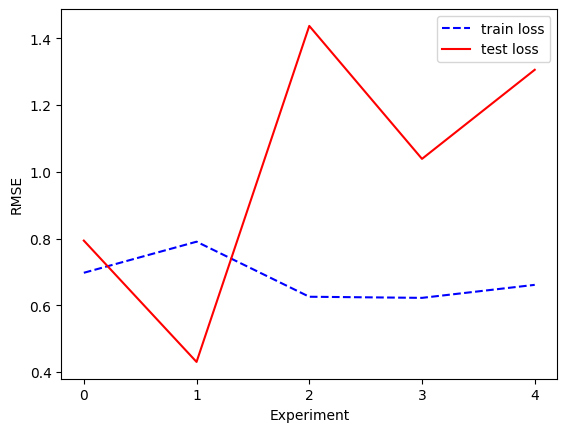

In [395]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(range(k_fold_splits), rmse_train, "b--", label = "train loss")
plt.plot(range(k_fold_splits), rmse_test, "r", label = "test loss")
ax = fig.gca()
ax.set_xticks(range(k_fold_splits))
plt.xlabel("Experiment")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [369]:
# Train model on all training data

rgdr.fit(precursor_field_sel, target_series_sel)

# transform to data
clusters = rgdr.transform(precursor_field_sel)

# train model
ridge = Ridge(alpha=1.0)
model = ridge.fit(clusters.isel(i_interval=0), target_series_sel.sel(i_interval=1))

model

Ridge()

In [370]:
print("Coefficients:", ridge.coef_)
print("Intercept:", ridge.intercept_)


Coefficients: [ 0.05057285 -0.95349356]
Intercept: 22.97864598202129


In [387]:
# Prepare test data
calendar.map_to_data(test_slice)
test_prep = preprocessor.transform(test_slice)
precursor_test_resample = lilio.resample(calendar, test_prep)
target_test_resample = lilio.resample(calendar, target_test_slice)
precursor_test_sel = precursor_test_resample['sst']
target_test_sel = target_test_resample['t2m'].sel(cluster=3)

clusters_test = rgdr.transform(precursor_test_sel)

clusters_test


<xarray.DataArray 'sst' (anchor_year: 17, i_interval: 1, cluster_labels: 2)> Size: 272B
array([[[ 0.25958101, -0.01672039]],

       [[-0.01424585,  0.5294146 ]],

       [[ 0.99769796, -0.13272906]],

       [[ 0.6400149 , -0.13042533]],

       [[ 0.59931508,  0.12927904]],

       [[ 2.02527765,  0.8346317 ]],

       [[ 0.72234007, -0.50274778]],

       [[ 1.71549421,  0.0622557 ]],

       [[ 0.43391405, -0.12973042]],

       [[ 0.44532889,  0.65404419]],

       [[ 0.62519466,  0.79633627]],

       [[ 0.63845581,  0.38719994]],

       [[-0.63588557, -0.54256273]],

       [[ 0.59690887, -0.07741515]],

       [[ 0.76285557,  0.51194448]],

       [[ 0.58419574,  0.37182693]],

       [[ 1.83170189,  1.53695643]]])
Coordinates:
  * anchor_year     (anchor_year) int64 136B 2004 2005 2006 ... 2018 2019 2020
  * i_interval      (i_interval) int64 8B -2
    left_bound      (anchor_year, i_interval) datetime64[ns] 136B 2004-04-01 ...
    right_bound     (anchor_year, i_interval) datetime64[ns] 136B 2004-05-01 ...
    is_target       (i_interval) bool 1B False
  * cluster_labels  (cluster_labels) int16 4B -2 -1
    latitude        (cluster_labels) float64 16B 42.5 43.4
    longitude       (cluster_labels) float64 16B 177.5 204.6
Attributes:
    data:         Clustered data with Response Guided Dimensionality Reduction.
    coordinates:  Latitudes and longitudes are geographical centers associate...

In [372]:
rgdr.corr_map

<xarray.DataArray (latitude: 5, longitude: 13)> Size: 520B
array([[-0.19709364, -0.30663844, -0.39371596, -0.42494307, -0.41893442,
        -0.40845739, -0.38510831, -0.37965749, -0.25314223, -0.18854893,
        -0.11709559,  0.08152539,         nan],
       [-0.3109853 , -0.28806029, -0.36593797, -0.46167947, -0.44894887,
        -0.41020272, -0.47796824, -0.4390566 , -0.43240435, -0.37552116,
        -0.1898937 , -0.0391329 ,         nan],
       [-0.20263631, -0.21352571, -0.26613064, -0.22284827, -0.23877426,
        -0.24213641, -0.26651751, -0.3424332 , -0.44109562, -0.39569154,
        -0.2226993 ,  0.05639238,         nan],
       [ 0.04339342,  0.09455391,  0.08207006,  0.09471236,  0.03892929,
        -0.02499523, -0.10221457, -0.24348893, -0.23177256, -0.22239319,
        -0.13891236,  0.00922853,  0.0515959 ],
       [ 0.23179083,  0.20966858,  0.20987571,  0.19041665,  0.10884458,
         0.10467675, -0.00958906, -0.01027452, -0.01779012,  0.09509262,
         0.05077161,  0.01386944,  0.12354364]])
Coordinates:
  * longitude   (longitude) float64 104B 177.5 182.5 187.5 ... 227.5 232.5 237.5
  * latitude    (latitude) float64 40B 47.5 42.5 37.5 32.5 27.5
    n_clusters  int64 8B 6
    cluster     int64 8B 3

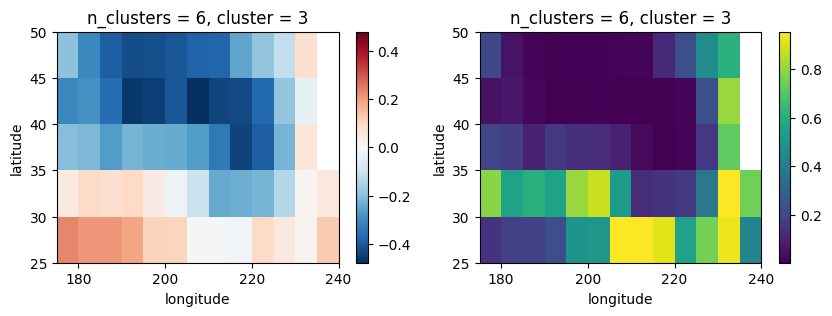

In [373]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 3), ncols=2)

# Visualize correlation map after RGDR().fit(precursor_field, target_timeseries)
rgdr.corr_map.plot(ax=ax1)

# Visualize p-values map
rgdr.pval_map.plot(ax=ax2)



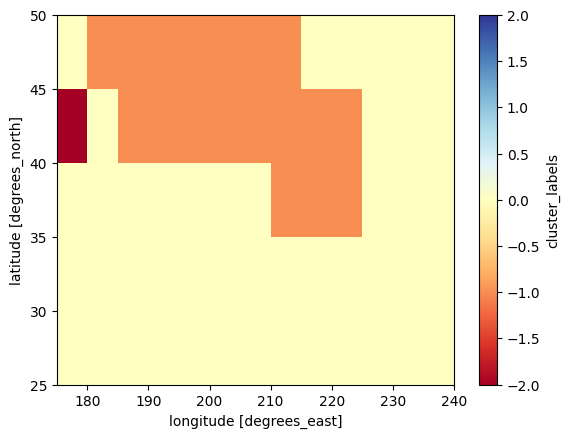

In [374]:
rgdr.cluster_map.plot(cmap='RdYlBu', vmin=-2, vmax=2)

In [375]:
# Predict on the training set
y_train_pred = ridge.predict(clusters.isel(i_interval=0))

# Predict on the test set
y_test_pred = ridge.predict(clusters_test.isel(i_interval=0))

# Evaluate performance
mse_train = mean_squared_error(target_series_sel.sel(i_interval=1), y_train_pred)
mse_test = mean_squared_error(target_test_sel.sel(i_interval=1), y_test_pred)

print("Training MSE:", mse_train)
print("Test MSE:", mse_test)


Training MSE: 0.7088438936211626
Test MSE: 1.4044770837087557


In [376]:
# Save model to ONNX 

onnx_model = to_onnx(model, clusters.isel(i_interval=0)[:1].values.astype(np.float32), target_opset=12)
# save model
with open("./model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [377]:
import onnxruntime as ort

# Load the ONNX model
model_path = 'model.onnx'
session = ort.InferenceSession(model_path)
pred_ort = session.run(None, {"X": clusters_test.isel(i_interval=0).values.astype(np.float32)})[0]

pred_ort


array([[23.007715],
       [22.473131],
       [23.155659],
       [23.135372],
       [22.885687],
       [22.285254],
       [23.494543],
       [23.006042],
       [23.124287],
       [22.37754 ],
       [22.250961],
       [22.64174 ],
       [23.463818],
       [23.082647],
       [22.529089],
       [22.653656],
       [21.605803]], dtype=float32)

In [378]:
import onnxruntime as ort
import dianna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from dianna.utils.onnx_runner import SimpleModelRunner
from dianna.utils.downloader import download

from numba.core.errors import NumbaDeprecationWarning
import warnings
# silence the Numba deprecation warnings in shap
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

def run_model(data):
    # get ONNX predictions
    sess = ort.InferenceSession(model_path)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    onnx_input = {input_name: data.astype(np.float32)}
    pred_onnx = sess.run([output_name], onnx_input)[0]
    
    return pred_onnx

In [382]:
data_instance = clusters_test.isel(i_interval=0).to_numpy()

clusters_test

<xarray.DataArray 'sst' (anchor_year: 17, i_interval: 1, cluster_labels: 2)> Size: 272B
array([[[ 0.25958101, -0.01672039]],

       [[-0.01424585,  0.5294146 ]],

       [[ 0.99769796, -0.13272906]],

       [[ 0.6400149 , -0.13042533]],

       [[ 0.59931508,  0.12927904]],

       [[ 2.02527765,  0.8346317 ]],

       [[ 0.72234007, -0.50274778]],

       [[ 1.71549421,  0.0622557 ]],

       [[ 0.43391405, -0.12973042]],

       [[ 0.44532889,  0.65404419]],

       [[ 0.62519466,  0.79633627]],

       [[ 0.63845581,  0.38719994]],

       [[-0.63588557, -0.54256273]],

       [[ 0.59690887, -0.07741515]],

       [[ 0.76285557,  0.51194448]],

       [[ 0.58419574,  0.37182693]],

       [[ 1.83170189,  1.53695643]]])
Coordinates:
  * anchor_year     (anchor_year) int64 136B 2004 2005 2006 ... 2018 2019 2020
  * i_interval      (i_interval) int64 8B -2
    left_bound      (anchor_year, i_interval) datetime64[ns] 136B 2004-04-01 ...
    right_bound     (anchor_year, i_interval) datetime64[ns] 136B 2004-05-01 ...
    is_target       (i_interval) bool 1B False
  * cluster_labels  (cluster_labels) int16 4B -2 -1
    latitude        (cluster_labels) float64 16B 42.5 43.4
    longitude       (cluster_labels) float64 16B 177.5 204.6
Attributes:
    data:         Clustered data with Response Guided Dimensionality Reduction.
    coordinates:  Latitudes and longitudes are geographical centers associate...

In [380]:
explanation = dianna.explain_tabular(run_model, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data = clusters.isel(i_interval=0).values.astype(np.float32), 
                                     training_data_kmeans = 5, feature_names=clusters_test.isel(i_interval=0).anchor_year)

explanation

  0%|          | 0/17 [00:00<?, ?it/s]

array([[ 1.32574354e-02,  2.04867863e-02],
       [-5.90823946e-04, -5.00249000e-01],
       [ 5.05864053e-02,  1.31101313e-01],
       [ 3.24971562e-02,  1.28904002e-01],
       [ 3.04386275e-02, -1.18722757e-01],
       [ 1.02553776e-01, -7.91271255e-01],
       [ 3.66607394e-02,  4.83911333e-01],
       [ 8.68878137e-02, -5.48163369e-02],
       [ 2.20741999e-02,  1.28241448e-01],
       [ 2.26516724e-02, -6.19082088e-01],
       [ 3.17480224e-02, -7.54757722e-01],
       [ 3.24182510e-02, -3.64648456e-01],
       [-3.20284934e-02,  5.21875086e-01],
       [ 3.03176471e-02,  7.83586729e-02],
       [ 3.87098449e-02, -4.83591874e-01],
       [ 2.96747344e-02, -3.49989732e-01],
       [ 9.27650588e-02, -1.46093353e+00]])

In [381]:
from dianna.visualization import plot_tabular

fig, _ = plot_tabular(explanation, str(clusters_test.isel(i_interval=0).anchor_year), num_features=10)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()